In [3]:

from datetime import datetime
import matplotlib

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn
import torch
import torch.nn.functional as F
from pytorch_forecasting import TimeSeriesDataSet
from lightning.pytorch.callbacks import EarlyStopping
import lightning.pytorch as pl

from pytorch_forecasting import TimeSeriesDataSet
from pyod.models.auto_encoder_torch import AutoEncoder
import matplotlib.pyplot as plt


In [6]:

import numpy as np
import pandas as pd


length = 3000

series = pd.DataFrame({
    "ds": pd.date_range("2021-01-01", periods=length, freq="D"),
    "y": np.sin(np.linspace(0, 100, length)) + 0.2 * np.random.randn(length)
})

# Inject anomalies
anomaly_indices = [250, 500, 700, 850]
anomaly_magnitudes = [5, -6, 8, -7]
series["is_anomaly"] = 0
for idx, mag in zip(anomaly_indices, anomaly_magnitudes):
    series.loc[idx, "y"] += mag
    series.loc[idx, "is_anomaly"] = 1

series["unique_id"] = "SYN"
series = series.reset_index().rename(columns={"ds": "ds"})

# Make sure 'ds' is datetime
series["ds"] = pd.to_datetime(series["ds"])



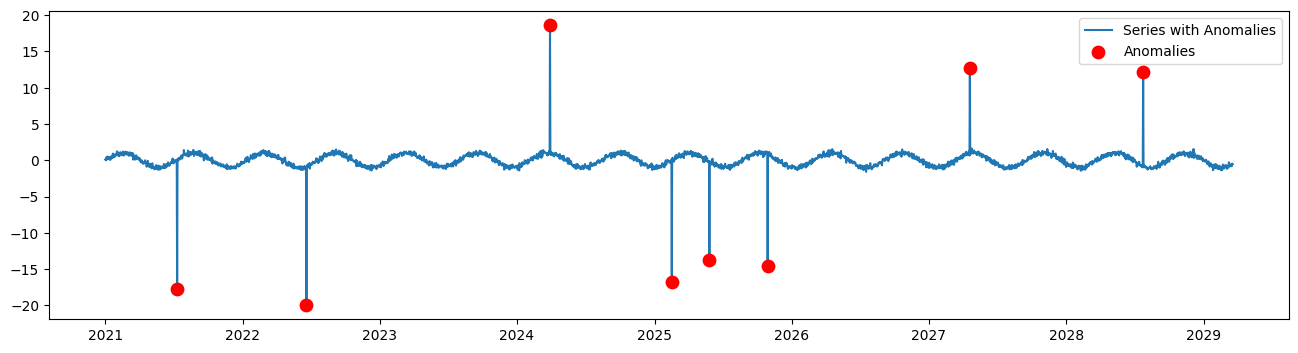

In [13]:
import numpy as np
import pandas as pd

def inject_anomalies(series, n_anomalies=8, magnitude_range=(5, 10), seed=None):
    """
    Injects anomalies into a time series DataFrame.
    Adds an 'is_anomaly' column (1 if anomaly, 0 otherwise).
    Randomly selects n_anomalies locations and modifies 'y' with a spike/drop.
    """
    if seed is not None:
        np.random.seed(seed)
    length = len(series)
    # Avoid the very start/end
    anomaly_indices = np.random.choice(np.arange(50, length-50), size=n_anomalies, replace=False)
    anomaly_magnitudes = np.random.uniform(*magnitude_range, size=n_anomalies)
    # Randomly choose if each is spike or drop
    anomaly_magnitudes *= np.random.choice([-1, 1], size=n_anomalies)
    series = series.copy()
    series["is_anomaly"] = 0
    for idx, mag in zip(anomaly_indices, anomaly_magnitudes):
        series.loc[idx, "y"] += mag
        series.loc[idx, "is_anomaly"] = 1
    return series, anomaly_indices, anomaly_magnitudes


N_LAGS = 96

np.random.seed(42)
length = 3000
series = pd.DataFrame({
    "ds": pd.date_range("2021-01-01", periods=length, freq="D"),
    "y": np.sin(np.linspace(0, 100, length)) + 0.2 * np.random.randn(length)
})

series, anomaly_indices, anomaly_magnitudes = inject_anomalies(series, n_anomalies=8, magnitude_range=(5, 10), seed=42)
series["is_anomaly"] = 0
for idx, mag in zip(anomaly_indices, anomaly_magnitudes):
    series.loc[idx, "y"] += mag
    series.loc[idx, "is_anomaly"] = 1

series["unique_id"] = "SYN"
series = series.reset_index().rename(columns={"ds": "ds"})

# Make sure 'ds' is datetime
series["ds"] = pd.to_datetime(series["ds"])

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.plot(series["ds"], series["y"], label="Series with Anomalies")
plt.scatter(series.loc[anomaly_indices, "ds"], series.loc[anomaly_indices, "y"], 
            color="red", label="Anomalies", zorder=5, s=80)
plt.legend()
plt.show()


In [14]:
df = series

In [16]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

series = series = df['y']
N_LAGS = 144

# Create sliding window input data
input_data = []
for i in range(N_LAGS, series.shape[0]):
    input_data.append(series.iloc[i - N_LAGS:i].values)

input_data = np.array(input_data)

# Normalize the input data
scaler = StandardScaler()
input_data_n = scaler.fit_transform(input_data)

# Convert to DataFrame for easier downstream processing
input_data_n = pd.DataFrame(input_data_n)

# Optional: reset index for clarity
input_data_n.reset_index(drop=True, inplace=True)


In [10]:


from pyod.models.auto_encoder_torch import AutoEncoder

model = AutoEncoder(
                    hidden_neurons=[144, 4, 4, 144],
                    hidden_activation="relu",
                    epochs=20,
                    batch_norm=True,
                    learning_rate=0.001,
                    batch_size=32,
                    dropout_rate=0.2,
                    )

model.fit(input_data_n)



InnerAutoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=144, out_features=144, bias=True)
    (batch_norm0): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=144, out_features=4, bias=True)
    (batch_norm1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=4, out_features=4, bias=True)
    (batch_norm2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.2, inplace=False)
    (linear3): Linear(in_features=4, out_features=144, bias=True)
    (batch_norm3): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (dropout3): Dropout(p=0.2, inplace=False)
  )
  (dec

AutoEncoder(batch_norm=True, batch_size=32, contamination=0.1,
      device=device(type='cpu'), dropout_rate=0.2, epochs=20,
      hidden_activation='relu', hidden_neurons=[144, 4, 4, 144],
      learning_rate=0.001, loss_fn=MSELoss(), preprocessing=True,
      weight_decay=1e-05)

In [11]:
anomaly_scores = model.decision_scores_

predictions = model.predict(input_data_n)

probs = model.predict_proba(input_data_n)[:, 1]
probabilities = pd.Series(probs, \
index=series.tail(len(probs)).index)


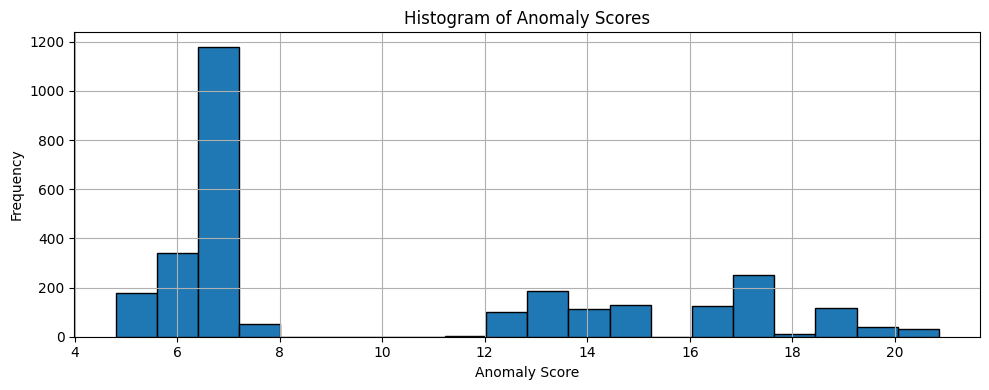

In [12]:

plt.figure(figsize=(10, 4))
plt.hist(anomaly_scores, bins=20, edgecolor='black')
plt.title("Histogram of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()




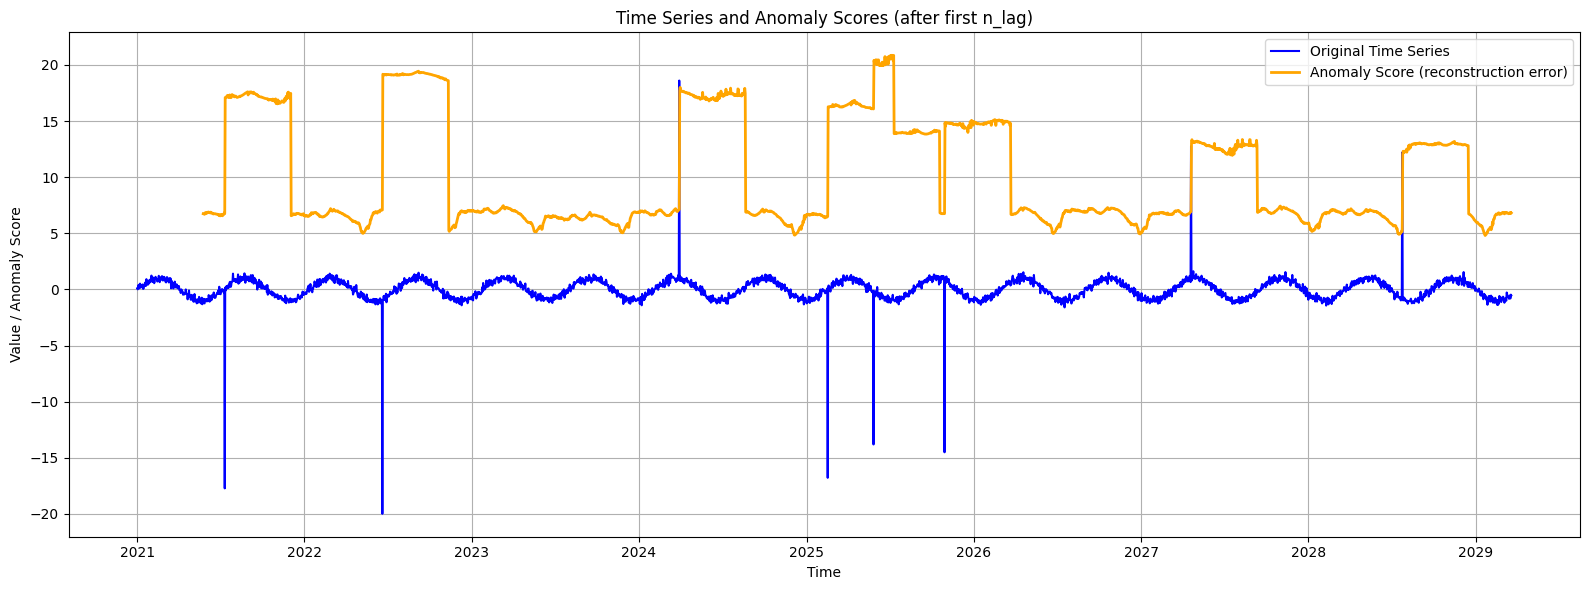

In [17]:

import matplotlib.pyplot as plt

# Calculate n_lag if not known
n_lag = df.shape[0] - anomaly_scores.shape[0]

plt.figure(figsize=(16, 6))

# Plot the full time series
plt.plot(df['ds'], df['y'], label="Original Time Series", color="blue")

# Overlay the anomaly scores (aligned, and optionally scaled if needed)
plt.plot(df['ds'][n_lag:].values, anomaly_scores, color="orange", label="Anomaly Score (reconstruction error)", linewidth=2)

plt.xlabel("Time")
plt.ylabel("Value / Anomaly Score")
plt.title("Time Series and Anomaly Scores (after first n_lag)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
